# loading libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pathlib
import pandas as pd
import numpy as np
import darts
from darts.models.forecasting.arima import ARIMA
from darts import TimeSeries
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os
import glob
from tqdm import tqdm
from darts.dataprocessing.transformers.scaler import Scaler

# Helping Functions


In [27]:
import numpy as np


def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape, "MSE": mse}

    return metrics

# Data Reading 😶

In [28]:
fileName = "highcorrelated_features"
df = pd.read_csv(f"../ProcessedData/{fileName}/{fileName}.csv")
df.head()

,date,net_sales_total,net_order_entry_total,mitarbeiter_vertrieb,mitarbeiter_service,mitarbeiter_total
0,2014-01-31,9914.85,13197.85,94,178,272
1,2014-02-28,8793.66,11632.08,96,178,274
2,2014-03-31,12689.12,14404.37,97,179,276
3,2014-04-30,12420.60,11512.26,97,180,277
4,2014-05-31,11825.02,11875.16,99,178,277


In [29]:
df = df[["date", "net_sales_total"]]
df = df.drop_duplicates()
df.head()

,date,net_sales_total
0,2014-01-31,9914.85
1,2014-02-28,8793.66
2,2014-03-31,12689.12
3,2014-04-30,12420.60
4,2014-05-31,11825.02


In [30]:
df.isna().sum()

date               0
net_sales_total    0
dtype: int64

# Box-Jenkins Framework
The Box-Jenkins method is a statistical technique used for time series analysis and forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using an ARMA model if it is stationary or an ARIMA model if it is non-stationary.

The Box-Jenkins method applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series2. The model can analyze several different types of time series data for forecasting purposes.

## ARIMA Model Pipeline
Autoregressive Integrated Moving Average (ARIMA) Model

* autoregressive models: AR(p)
* moving average models: MA(q)
* mixed autoregressive moving average models: ARMA(p, q)
* integration models: ARIMA(p, d, q)
### Stationary Test
What is stationary Data ?
Stationary data refers to time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.

* **Why we need stationary Data for ARIMA Model**  
ARIMA models rely on the assumption that the time series being modeled is stationary. Therefore that assumption needs to hold if you want to use these models. The ARIMA model uses differenced data to make the data stationary, which means there’s a consistency of the data over time. This function removes the effect of trends or seasonality, such as market or economic data. We make the data stationary only in case of ARIMA because the ARIMA model looks at the past data to predict future values.

In [31]:
def adfuller_test(values):
    result = adfuller(values)
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print(
            "P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary"
        )
    else:
        print(
            "Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary "
        )

In [32]:
adfuller_test(df["net_sales_total"])

ADF Test Statistic : -0.5945418906256462
p-value : 0.8722105724767181
#Lags Used : 13
Number of Observations Used : 94
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


In [33]:
adfuller_test(df["net_sales_total"].diff(1).iloc[1:])

ADF Test Statistic : -4.015772404893064
p-value : 0.0013301372561128658
#Lags Used : 12
Number of Observations Used : 94
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


## Spliting Data into Training & Testing Data

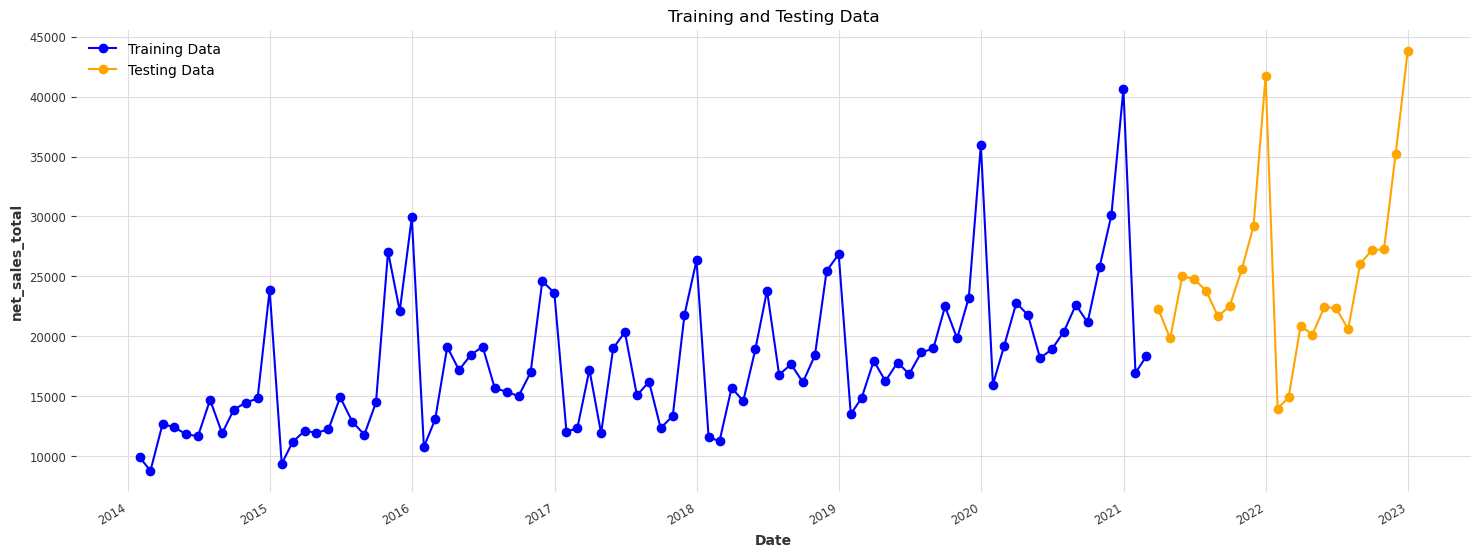

In [34]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(
    df, "date", "net_sales_total", freq="1M", fill_missing_dates=True, fillna_value=0
)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_series.plot(label="Training Data", color="blue", linewidth=1.5, marker="o")
test_series.plot(label="Testing Data", color="orange", linewidth=1.5, marker="o")

# Add title and labels
plt.title("Training and Testing Data")
plt.xlabel("Date")
plt.ylabel("net_sales_total")

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

## Inspect Seasonality

In [35]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 6.
There is seasonality of order 12.
There is seasonality of order 15.
There is seasonality of order 18.


## Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the **MA** component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component should be included in the ARIMA model.

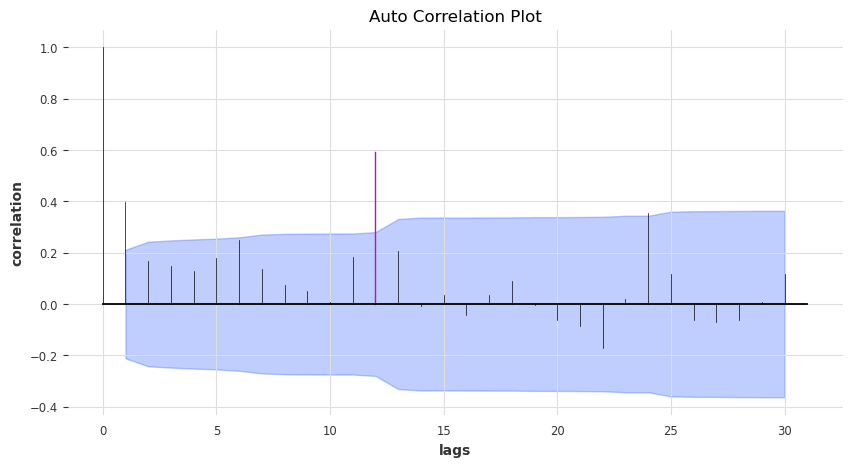

In [36]:
from darts.utils.statistics import plot_acf, plot_pacf


plot_acf(
    train_series, m=12, max_lag=30, fig_size=(10, 5), axis=None, default_formatting=True
)
plt.xlabel("lags")
plt.ylabel("correlation")
plt.title("Auto Correlation Plot")
plt.show()

## Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the **AR** component of the ARIMA model.

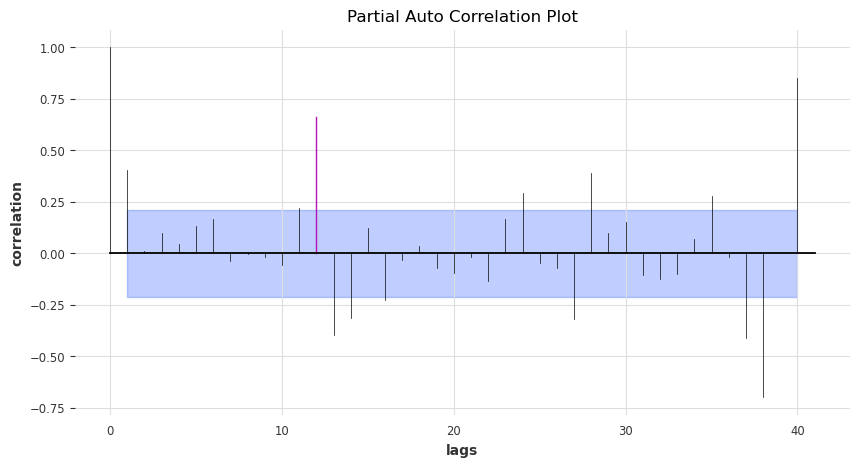

In [37]:
from darts.utils.statistics import plot_acf, plot_pacf

plot_pacf(
    train_series, m=12, max_lag=40, fig_size=(10, 5), axis=None, default_formatting=True
)

plt.xlabel("lags")
plt.ylabel("correlation")
plt.title("Partial Auto Correlation Plot")
plt.show()

# Model Fitting

## ARIMA Model Fitting

In [38]:
from darts.dataprocessing.transformers.scaler import Scaler

arima_model = ARIMA(
    p=12,
    d=1,
    q=12,
    trend=None,
    random_state=1999,
    add_encoders={
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["hour", "dayofweek"]},
        "position": {"future": ["relative"]},
        "custom": {"future": [lambda idx: (idx.year - 1950) / 50]},
        "transformer": Scaler(),
    },
)

arima_model.fit(train_series)
arima_model.model.summary()

/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   86
Model:               ARIMA(12, 1, 12)   Log Likelihood                -784.228
Date:                Fri, 15 Sep 2023   AIC                           1630.456
Time:                        21:30:51   BIC                           1706.178
Sample:                             0   HQIC                          1660.913
                                 - 86                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          4748.6318    984.993      4.821      0.000    2818.081    6679.183
x2           559.2408    889.219      0.629      0.529   -1183.596    2302.078
const       7.522e-10   1.72e+05   4.38e-15      1.000   -3.36e+05    3.36e+05
x3           -56.8731   1033.904     -0.055      0.956   -2083.288    1969.542
x4          1.525e+05   2.29e+04      6.652      0.000    1.08e+05    1.97e+05
x5         -1.455e+05   2.06e+04     -7.063      0.000   -1.86e+05   -1.05e+05
ar.L1         -0.8613     10.035     -0.086      0.932     -20.529      18.806
ar.L2         -0.7410     17.841     -0.042      0.967     -35.708      34.226
ar.L3         -0.3877     23.874     -0.016      0.987     -47.180      46.404
ar.L4         -0.5524     25.899     -0.021      0.983     -51.313      50.208
ar.L5         -0.2452     29.308     -0.008      0.993     -57.688      57.197
ar.L6          0.2335     29.407      0.008      0.994     -57.403      57.870
ar.L7          0.3600     24.688      0.015      0.988     -48.028      48.748
ar.L8          0.1607     19.247      0.008      0.993     -37.563      37.884
ar.L9          0.4166     16.197      0.026      0.979     -31.328      32.161
ar.L10         0.5511     10.895      0.051      0.960     -20.804      21.906
ar.L11         0.4378      4.739      0.092      0.926      -8.851       9.727
ar.L12         0.0255      0.363      0.070      0.944      -0.687       0.738
ma.L1          0.2379      9.745      0.024      0.981     -18.863      19.338
ma.L2          0.0996     12.364      0.008      0.994     -24.133      24.332
ma.L3         -0.2286     11.980     -0.019      0.985     -23.709      23.252
ma.L4          0.2461      8.897      0.028      0.978     -17.191      17.683
ma.L5         -0.1394     10.175     -0.014      0.989     -20.083      19.804
ma.L6         -0.3538      8.072     -0.044      0.965     -16.175      15.467
ma.L7         -0.2480      5.363     -0.046      0.963     -10.759      10.263
ma.L8          0.0291      1.820      0.016      0.987      -3.539       3.597
ma.L9         -0.5636      1.608     -0.351      0.726      -3.714       2.587
ma.L10        -0.2615      5.293     -0.049      0.961     -10.635      10.112
ma.L11        -0.1859      6.350     -0.029      0.977     -12.632      12.260
ma.L12         0.7200      7.773      0.093      0.926     -14.515      15.955
sigma2       5.59e+06    166.901   3.35e+04      0.000    5.59e+06    5.59e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                16.97
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.49
Prob(H) (two-sided):                  0.58   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

FileNotFoundError: [Errno 2] No such file or directory: '../ProcessedData/Results/ARIMA/highcorrelated_features/ARIMA_Plots/utilized_all.png'

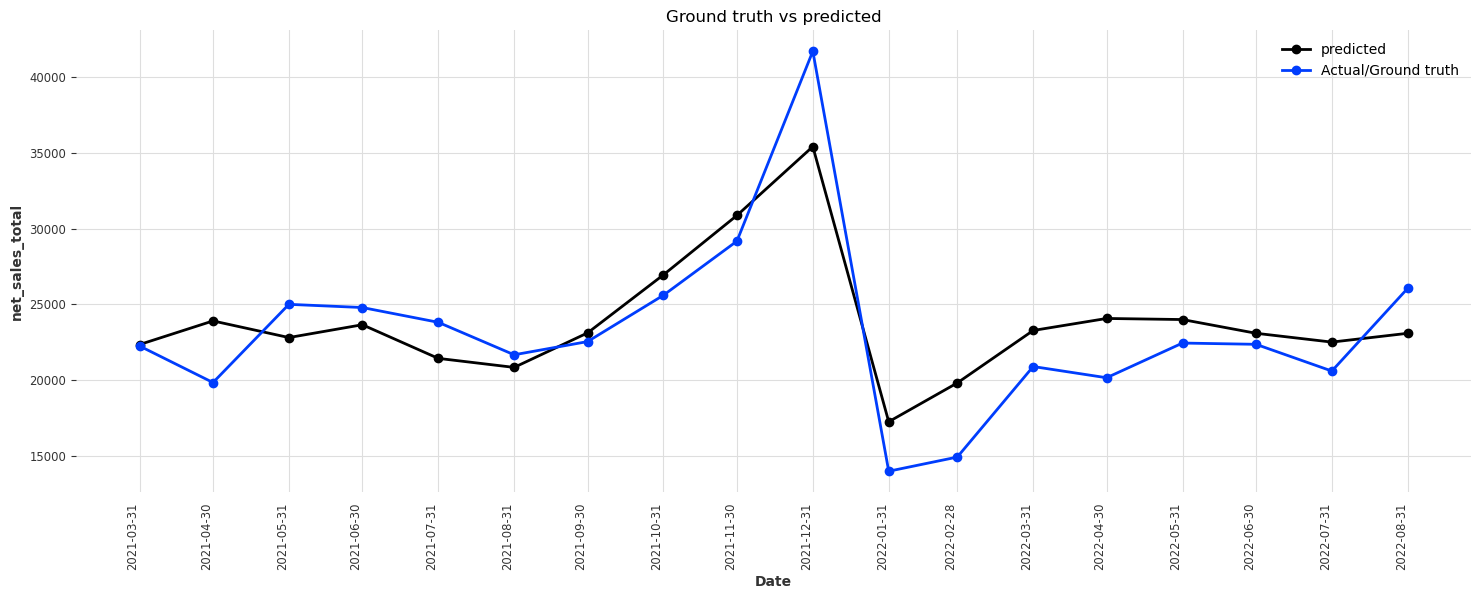

In [39]:
horizan = 18
test_series_ = test_series[0:horizan]
plt.figure(figsize=(18, 6))

forcast_arima = arima_model.predict(horizan)
arima_model.predict(horizan).plot(marker="o", label="predicted")
test_series_.plot(marker="o", label="Actual/Ground truth")
# Add title and labels
plt.title("Ground truth vs predicted")
plt.xlabel("Date")
plt.ylabel("net_sales_total")
plt.xticks(
    forcast_arima.time_index, forcast_arima.time_index.strftime("%Y-%m-%d"), rotation=90
)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.savefig(
    f"../ProcessedData/Results/ARIMA/highcorrelated_features/ARIMA_Plots/utilized_all.png"
)
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Function to predict and evaluate
def predict_and_evaluate(
    window_size,
    prediction_horizon,
    slide_step,
    test_series,
    arima_model,
    result_plot_path,
):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1

    meta_information_evaluation = {
        "Iterations": [],
        "MAE": [],
        "RMSE": [],
        "MAPE": [],
        "MSE": [],
        "input_window_size": [],
        "horizon": [],
        "stride": [],
    }

    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i : i + window_size]
            ground_truth = test_series[
                i + window_size : i + window_size + prediction_horizon
            ]
            forecast = arima_model.predict(n=prediction_horizon, series=input_window)
            actual = ground_truth.values().flatten().tolist()
            predicted = forecast.values().flatten().tolist()
            print("Predicted:", predicted)
            metrics = calculate_metrics(actual, predicted)

            meta_information_evaluation["Iterations"].append(i)
            meta_information_evaluation["MAE"].append(metrics["MAE"])
            meta_information_evaluation["RMSE"].append(metrics["RMSE"])
            meta_information_evaluation["MAPE"].append(metrics["MAPE"])
            meta_information_evaluation["MSE"].append(metrics["MSE"])
            meta_information_evaluation["input_window_size"].append(window_size)
            meta_information_evaluation["horizon"].append(prediction_horizon)
            meta_information_evaluation["stride"].append(slide_step)

            bypass_information = {
                "slide_step": slide_step,
                "window_size": window_size,
                "horizon": prediction_horizon,
            }
            create_plots(
                input_window,
                forecast,
                ground_truth,
                result_plot_path,
                bypass_information,
            )

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df

    except Exception as e:
        print("Error Occurred in fuction predict_and_evaluate():", e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df


# Function to create plots
def create_plots(
    input_window, forecast, ground_truth, result_plot_path, bypass_information
):
    plt.figure(figsize=(30, 6))
    input_window.plot(label="Input Data", marker="o")
    forecast.plot(label="Predicted", marker="o")
    ground_truth.plot(label="Ground Truth", marker="o")

    combined_time_index = input_window.time_index.append(forecast.time_index).append(
        ground_truth.time_index
    )
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")

    plt.xticks(
        combined_time_index, combined_time_index.strftime("%Y-%m-%d"), rotation=90
    )
    plt.title(
        f"Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}",
        fontsize=16,
    )
    plt.ylabel("net_sales_total", fontsize=14)
    plt.xlabel("Dates", fontsize=14)
    plt.legend()

    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    plt.close()
    # plt.show()

# Model Evaluation

In [ ]:
def model_evaluation(model_name, model_object, test_series, FileName):
    result_path = f"../ProcessedData/Results/{model_name}/{FileName}"
    result_plot_path = (
        f"../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots"
    )
    os.makedirs(result_path, exist_ok=True)
    os.makedirs(result_plot_path, exist_ok=True)

    # Set your parameters
    window_sizes = [6, 12, 18]
    prediction_horizons = [6, 12, 18]
    slide_steps = [2, 5, 8]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(
                    f"Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}"
                )
                evaluation_df = predict_and_evaluate(
                    window_size,
                    prediction_horizon,
                    slide_step,
                    test_series,
                    model,
                    result_plot_path,
                )
                evaluation_df.to_csv(
                    f"{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv",
                    index=False,
                )

                print(
                    f"Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed."
                )
            #         break
        #     break
        # break

##  ARIMA Model Evaluation

In [ ]:
model_name = "ARIMA"
FileName = fileName
model_object = arima_model
test_series = test_series
model_evaluation(model_name, model_object, test_series, FileName)

Iteration : Window size : 6 Horizan: 6, Stride : 2


  0%|          | 0/6 [00:00<?, ?it/s]

Predicted: [23285.701374473065, 26457.233712060686, 31082.8397817964, 32877.298948370015, 17333.133570332095, 16108.80827204345]


 17%|█▋        | 1/6 [00:00<00:03,  1.46it/s]

Predicted: [30527.082936600807, 35491.62624901946, 18276.129042229048, 17808.65783645488, 21625.990825783687, 18784.25622423477]


 33%|███▎      | 2/6 [00:01<00:02,  1.61it/s]

Predicted: [19733.94025775145, 22817.358184697197, 23920.610982345723, 21330.903000660597, 24174.99426140503, 19315.398744428887]


 50%|█████     | 3/6 [00:01<00:01,  1.66it/s]

Predicted: [20360.960560085077, 23071.968077982383, 23653.20165167831, 19249.609569220385, 18934.27419479274, 13617.890950505403]


 67%|██████▋   | 4/6 [00:02<00:01,  1.58it/s]

Predicted: [22532.27206483135, 22903.260983159045, 20289.382255567223, 15493.969714176776, 19574.6748670452, 18622.58181560476]


 83%|████████▎ | 5/6 [00:03<00:00,  1.40it/s]

Predicted: [19656.351887879937, 20378.70253417448, 21860.514170286384, 20189.61147239044, 26706.02863803238, 24469.79957788842]


100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


Window_size_6_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 5


  0%|          | 0/3 [00:00<?, ?it/s]

Predicted: [23285.701374473065, 26457.233712060686, 31082.8397817964, 32877.298948370015, 17333.133570332095, 16108.80827204345]


 33%|███▎      | 1/3 [00:00<00:01,  1.64it/s]

Predicted: [20303.237010126115, 22759.549566583493, 24156.114857656314, 20754.191333927, 22498.964198935286, 15582.23236111016]


 67%|██████▋   | 2/3 [00:01<00:00,  1.71it/s]

Predicted: [19656.351887879937, 20378.70253417448, 21860.514170286384, 20189.61147239044, 26706.02863803238, 24469.79957788842]


100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


Window_size_6_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 8


  0%|          | 0/2 [00:00<?, ?it/s]

Predicted: [23285.701374473065, 26457.233712060686, 31082.8397817964, 32877.298948370015, 17333.133570332095, 16108.80827204345]


 50%|█████     | 1/2 [00:00<00:00,  1.84it/s]

Predicted: [22532.27206483135, 22903.260983159045, 20289.382255567223, 15493.969714176776, 19574.6748670452, 18622.58181560476]


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


Window_size_6_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 2


  0%|          | 0/3 [00:00<?, ?it/s]

Predicted: [23285.701374473065, 26457.233712060686, 31082.8397817964, 32877.298948370015, 17333.1335703321, 16108.808272043443, 23152.494359697364, 22837.334617373337, 21600.58284775311, 23477.39168197092, 21612.601581108596, 21922.424858950857]


 33%|███▎      | 1/3 [00:00<00:01,  1.62it/s]

Predicted: [30527.082936600807, 35491.62624901946, 18276.129042229048, 17808.65783645488, 21625.990825783676, 18784.25622423477, 24664.471199157786, 23238.606422778732, 19122.47109509243, 22202.897404520292, 23239.50543680965, 26140.099350212717]


 67%|██████▋   | 2/3 [00:01<00:00,  1.65it/s]

Predicted: [19733.94025775145, 22817.358184697197, 23920.610982345723, 21330.903000660597, 24174.994261405027, 19315.398744428876, 24417.147600735647, 22739.015040279482, 19656.653647500247, 27804.66525281884, 30150.392106021583, 36369.094621788005]


100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


Window_size_6_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 5


  0%|          | 0/1 [00:00<?, ?it/s]

Predicted: [23285.701374473065, 26457.233712060686, 31082.8397817964, 32877.298948370015, 17333.1335703321, 16108.808272043443, 23152.494359697364, 22837.334617373337, 21600.58284775311, 23477.39168197092, 21612.601581108596, 21922.424858950857]


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


Window_size_6_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 8


  0%|          | 0/1 [00:00<?, ?it/s]

Predicted: [23285.701374473065, 26457.233712060686, 31082.8397817964, 32877.298948370015, 17333.1335703321, 16108.808272043443, 23152.494359697364, 22837.334617373337, 21600.58284775311, 23477.39168197092, 21612.601581108596, 21922.424858950857]


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Window_size_6_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 2


  0%|          | 0/3 [00:00<?, ?it/s]

Predicted: [23463.457006001827, 23015.018448699244, 20778.058840734044, 25116.084799067565, 21578.43169225771, 21647.71979141031]


 33%|███▎      | 1/3 [00:00<00:01,  1.76it/s]

Predicted: [25992.433070950163, 23924.78796047064, 17085.430700641544, 21981.63924863874, 22929.24009157772, 27614.04132375918]


 67%|██████▋   | 2/3 [00:01<00:00,  1.75it/s]

Predicted: [23760.460951451423, 21273.1761571525, 17342.916402265128, 28503.152371534226, 30414.295116582565, 36387.95782758605]


100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Window_size_12_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 5


  0%|          | 0/1 [00:00<?, ?it/s]

Predicted: [23463.457006001827, 23015.018448699244, 20778.058840734044, 25116.084799067565, 21578.43169225771, 21647.71979141031]


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Window_size_12_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 8


  0%|          | 0/1 [00:00<?, ?it/s]

Predicted: [23463.457006001827, 23015.018448699244, 20778.058840734044, 25116.084799067565, 21578.43169225771, 21647.71979141031]


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Window_size_12_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 8


0it [00:00, ?it/s]

Window_size_18_prediction_horizon_18_slide_step_8 - Evaluation completed.


# Evaluate Metrics

In [ ]:
import pandas as pd
import glob


def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        "window_size": [],
        "horizan": [],
        "stride": [],
        "AVG_MAE": [],
        "AVG_MSE": [],
        "AVG_RMSE": [],
        "AVG_MAPE": [],
    }

    paths = glob.glob(file_pattern)

    for path in paths:
        # print(path)
        window_size = path.split("/")[-1].split("_")[2]
        horizan = path.split("/")[-1].split("_")[4]
        stride = path.split("/")[-1].split("_")[6].split(".")[0]

        df = pd.read_csv(path)

        eval_dict["window_size"].append(window_size)
        eval_dict["horizan"].append(horizan)
        eval_dict["stride"].append(stride)

        eval_dict["AVG_MAE"].append(df["MAE"].mean())
        eval_dict["AVG_MSE"].append(df["MSE"].mean())
        eval_dict["AVG_RMSE"].append(df["RMSE"].mean())
        eval_dict["AVG_MAPE"].append(df["MAPE"].mean())

    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(
        ["window_size", "horizan", "stride"], inplace=True, ascending=True
    )

    return eval_df


# Example usage
file_pattern = f"../ProcessedData/Results/ARIMA/{fileName}/*.csv"
result_df = aggregate_evaluation_results(file_pattern)
# result_df = result_df[
#     ["window_size", "horizan", "stride", "AVG_MAE", "AVG_MSE", "AVG_RMSE"]
# ]
result_df

,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
34,12,6,10,2543.463886,7.610925e+06,2758.790520,11.335480
50,12,6,15,2543.463886,7.610925e+06,2758.790520,11.335480
70,12,6,2,3549.569636,1.767583e+07,3966.796653,13.649738
42,12,6,5,2543.463886,7.610925e+06,2758.790520,11.335480
1,12,6,8,2543.463886,7.610925e+06,2758.790520,11.335480
64,6,12,2,3050.721949,1.447635e+07,3717.312040,13.426705
29,6,12,5,2415.798525,1.070700e+07,3272.155274,10.022411
69,6,12,8,2415.798525,1.070700e+07,3272.155274,10.022411
49,6,6,2,4250.837346,3.517281e+07,5557.561640,17.213161
46,6,6,5,4552.401746,4.065282e+07,5742.408892,16.906025


In [ ]:
list(result_df)

['window_size', 'horizan', 'stride', 'AVG_MAE', 'AVG_MSE', 'AVG_RMSE']

In [21]:
result_df

,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
5,30,15,10,15.037947,789.402475,22.080949
15,30,15,15,13.489363,631.330471,20.278487
23,30,15,5,14.523340,709.618812,21.365757
14,30,30,10,18.353296,1040.850665,26.438658
26,30,30,15,16.962681,904.838498,25.110198
10,30,30,5,17.940599,971.298462,25.847410
16,30,35,10,19.593409,1150.151343,27.771255
2,30,35,15,17.857009,967.418924,26.021316
3,30,35,5,19.072580,1061.769273,27.167792
8,45,15,10,14.099128,646.030707,20.743455


In [20]:
for name, group in result_df.groupby(["window_size", "horizan"]):
    print(name)
    display(group)

('30', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
5,30,15,10,15.037947,789.402475,22.080949
15,30,15,15,13.489363,631.330471,20.278487
23,30,15,5,14.523340,709.618812,21.365757


('30', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
14,30,30,10,18.353296,1040.850665,26.438658
26,30,30,15,16.962681,904.838498,25.110198
10,30,30,5,17.940599,971.298462,25.847410


('30', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
16,30,35,10,19.593409,1150.151343,27.771255
2,30,35,15,17.857009,967.418924,26.021316
3,30,35,5,19.072580,1061.769273,27.167792


('45', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
8,45,15,10,14.099128,646.030707,20.743455
20,45,15,15,13.680710,647.435979,20.540705
18,45,15,5,14.528636,713.605299,21.171357


('45', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
19,45,30,10,17.357449,897.980151,24.946752
11,45,30,15,16.792153,899.368653,24.817340
9,45,30,5,17.795366,968.404699,25.470509


('45', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
4,45,35,10,18.362091,973.781350,26.330085
7,45,35,15,17.698690,966.301824,25.784215
13,45,35,5,18.923794,1065.279267,26.912764


('90', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
12,90,15,10,15.725033,845.455838,22.185467
25,90,15,15,14.234027,669.513128,20.702042
24,90,15,5,15.136375,762.804120,21.715795


('90', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
1,90,30,10,19.305237,1146.355733,27.263261
22,90,30,15,17.625344,974.471960,25.749411
17,90,30,5,18.837731,1071.892204,26.817739


('90', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
0,90,35,10,20.703196,1285.338767,28.990219
6,90,35,15,18.449222,1042.854908,26.666015
21,90,35,5,20.019347,1181.212888,28.360803
